In [1]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Activation, ReLU, Flatten, Dense, Add,\
    Dropout,MaxPooling2D,Concatenate,Reshape
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
import warnings
from pathlib import Path
# Tüm uyarıları kapat
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns

2024-06-21 05:34:08.432621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 05:34:08.432733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 05:34:08.691962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Create the labels and enter the Data_Path.

In [2]:
DATA_PATH = Path("Potato Leaf DIsease")
labels = ['Early Blight', 'Fungal Diseases','Healthy','Late Blight','Plant Pests','Potato Cyst Nematode','Potato Virus']

# Setting Seeds

In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Since we don't have a CSV file, we are creating a CSV file that contains our images including File, Disease Id, and Disease Type

In [4]:
data=[]
for disease_id , sp in enumerate(labels):
    for file in os.listdir(os.path.join(DATA_PATH, sp)):
        data.append(['{}/{}'.format(sp, file), disease_id, sp])
csv_data = pd.DataFrame(data, columns=['File', 'Disease Id', 'Disease Type'])
csv_data

,File,Disease Id,Disease Type
0,Early Blight/early blight (422).JPG,0,Early Blight
1,Early Blight/early blight (269).JPG,0,Early Blight
2,Early Blight/early blight (34).JPG,0,Early Blight
3,Early Blight/early blight (290).JPG,0,Early Blight
4,Early Blight/early blight (32).JPG,0,Early Blight
...,...,...,...
3495,Potato Virus/potato virus (242).jpg,6,Potato Virus
3496,Potato Virus/potato virus (474).jpg,6,Potato Virus
3497,Potato Virus/potato virus (37).JPG,6,Potato Virus
3498,Potato Virus/potato virus (45).jpg,6,Potato Virus


# Check if there is a null value in data

In [5]:
csv_data.isnull().sum()

File            0
Disease Id      0
Disease Type    0
dtype: int64

# Creating our image reading and resizing functions

In [6]:
IMAGE_SIZE = 112

def read_image(filepath):
    return cv2.imread(os.path.join(DATA_PATH, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [7]:
X_data_item = np.zeros((csv_data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(csv_data['File'].values)):
    image = read_image(file)
    if image is not None:
        X_data_item[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize data
X_data = X_data_item #/ 255.0
print('Train Shape: {}'.format(X_data.shape))

Y_data = csv_data['Disease Id'].values
Y_data = to_categorical(Y_data)

3500it [00:22, 153.21it/s]

Train Shape: (3500, 112, 112, 3)


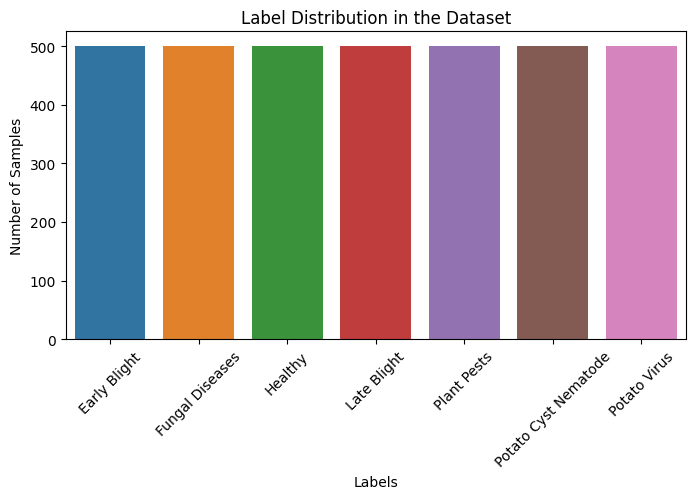

In [8]:
class_counts = csv_data['Disease Type'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

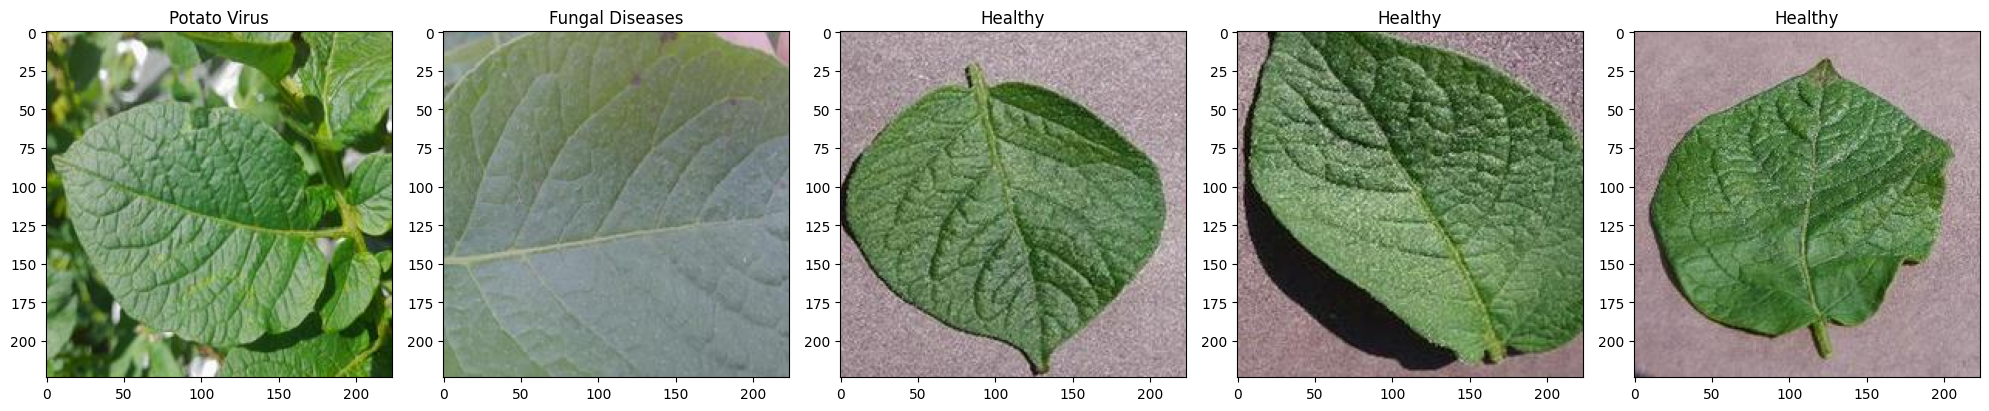

In [9]:
from PIL import Image

_, axs = plt.subplots(1, 5, figsize=(20, 5))

for j in range(5):
    index = np.random.randint(0,len(csv_data))
    img_path = csv_data.iloc[index]['File']
    label = csv_data.iloc[index]['Disease Type']
    img = Image.open(str(DATA_PATH)+"/"+img_path)
    axs[j].imshow(img)
    axs[j].set_title(label)
plt.tight_layout()
plt.show()

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

In [12]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2240, 112, 112, 3),
 (2240, 7),
 (700, 112, 112, 3),
 (700, 7),
 (560, 112, 112, 3),
 (560, 7))

In [13]:
basemodel = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet', classes=7)
basemodel2 = ResNet50(include_top=False)

for layer in basemodel.layers:
    layer.trainable = True
for layer in basemodel2.layers:
    layer.trainable = True

global_pooling_layer1 = GlobalAveragePooling2D()(basemodel.output)
global_pooling_layer2 = GlobalAveragePooling2D()(basemodel2.output)

global_pooling_layer1 = Reshape((1, 1, global_pooling_layer1.shape[1]))(global_pooling_layer1)
global_pooling_layer2 = Reshape((1, 1, global_pooling_layer2.shape[1]))(global_pooling_layer2)

concatenated_output = Concatenate()([global_pooling_layer1, global_pooling_layer2])

flatten_layer = Flatten()(concatenated_output)

# Dropout ve çıkış katmanı
dropout_layer = Dropout(0.4)(flatten_layer)
output_layer = Dense(7, activation='softmax')(dropout_layer)

model = Model(inputs=[basemodel.input,basemodel2.input], outputs=output_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from keras.metrics import Precision, Recall,AUC,F1Score
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # lr=0.0001 , 0.1
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall(), AUC(), F1Score()])
# model.summary() ön eğitimli ağda çok fazla katman bulunduğu için boş yer kaplıyor

In [15]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Kendi Callbackim
class EarlyStoppingAtThreshold(tf.keras.callbacks.Callback):# kerasın içindeki callback den kalıtım aldık
    def __init__(self, monitor, threshold, patience = 0, restore_best_weights=False):
        super(EarlyStoppingAtThreshold, self).__init__()
        self.monitor = monitor # izlenmesi gereken metrik
        self.threshold = threshold # hangi değerde duracağımız
        self.patience = patience # o değere ulaştıktan sonra kaç epoch devam etsin
        self.restore_best_weights = restore_best_weights # en iyi ağırlıklar
        self.wait = 0 # bunu wait > patience için tanımlandı
        self.best_weights = None # en iyi ağırlıklarımızı tutacak
        self.best = -float('inf') # metriğin en yüksek değeri

    def on_train_begin(self, logs=None): # eğitime başlangıç anında olacaklar
        self.wait = 0
        self.best = -float('inf')
        if self.restore_best_weights: # True ise modelin ilk ağırlığını best_weights e atacak
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None): # eğitimin sonunda olacaklar
        current = logs.get(self.monitor) # izlencek metriğin değerini çekiyoruz
        if current is None:
            print(f"Warning: Metric '{self.monitor}' is not available.")
            return

        if current > self.best: # eğer metriğin değeri öncekinden yüksekse
            self.best = current # en yüksek metirk değerini değiştiriyoruz
            self.wait = 0
            if self.restore_best_weights: # true ise
                self.best_weights = self.model.get_weights() # en iyi ağırlığı güncelliyoruz
        elif current >= self.threshold: # metriğin değeri istediğimiz değeri geçtiyse
            self.wait += 1 # beklemeyi 1 arttırıyoruz
            if self.wait > self.patience: # wait > patience olunca
                # istediğimiz değere geldi durduruyoruz
                print(f"\nReached {self.threshold*100}% {self.monitor}. Stopping training after {self.patience} more epochs.")
                if self.restore_best_weights:# True ise
                    print("Restoring model weights from the best epoch.")
                    self.model.set_weights(self.best_weights)# en iyi ağırlıkları ayarlıyoruz
                self.model.stop_training = True #modeli durduruyoruz

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=5, cooldown=3, min_lr=1e-4, verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, restore_best_weights=False)

early_stoppin_at_threshold = EarlyStoppingAtThreshold(monitor='val_accuracy', threshold=0.94, patience = 2, restore_best_weights=True)

calbacks=[early_stopping,reduce_lr,early_stoppin_at_threshold]

In [16]:
batch_size = 64
epochs = 50
hist_concat = model.fit(
    [X_train, X_train],Y_train,
    epochs=epochs,
    batch_size=batch_size,
#    shuffle=True,
    validation_data=([X_val,X_val],Y_val),
    callbacks=calbacks
    )

Epoch 1/50


I0000 00:00:1718948274.487167      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718948274.700242      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5785 - auc: 0.8653 - f1_score: 0.5771 - loss: 1.2846 - precision: 0.6971 - recall: 0.4727

W0000 00:00:1718948296.394971      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718948313.884422      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5818 - auc: 0.8671 - f1_score: 0.5804 - loss: 1.2749 - precision: 0.7003 - recall: 0.4761 - val_accuracy: 0.1157 - val_auc: 0.4841 - val_f1_score: 0.0512 - val_loss: 2285.0911 - val_precision: 0.1157 - val_recall: 0.1157 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.8680 - auc: 0.9823 - f1_score: 0.8676 - loss: 0.4165 - precision: 0.9099 - recall: 0.8362 - val_accuracy: 0.2714 - val_auc: 0.6145 - val_f1_score: 0.2117 - val_loss: 7.6447 - val_precision: 0.2787 - val_recall: 0.2671 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.9451 - auc: 0.9967 - f1_score: 0.9449 - loss: 0.1707 - precision: 0.9532 - recall: 0.9298 - val_accuracy: 0.6000 - val_auc: 0.8442 - val_f1_score: 0.5370 - val_loss: 3.3611 - val_precision: 0.6056 - val_recall: 0.5857 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - accuracy: 0.9563 - auc: 0.99

In [17]:
y_pred = model.predict([X_test,X_test])
y_pred = np.argmax(y_pred, axis=1).reshape(-1, 1)
Y_test = np.argmax(Y_test, axis=1).reshape(-1, 1)

 4/18 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

W0000 00:00:1718948740.779823      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step


W0000 00:00:1718948758.175045      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [18]:
print(" MODEL RESULTS")
print("Accuracy: ", accuracy_score(Y_test, y_pred))
print("F1_Score: ", f1_score(Y_test, y_pred, average='macro'))
print("Precision: ", precision_score(Y_test, y_pred, average='macro'))
print("Sensitivity: ", recall_score(Y_test, y_pred, average='macro'))

 MODEL RESULTS
Accuracy:  0.8767857142857143
F1_Score:  0.8787303549255548
Precision:  0.8802588463582005
Sensitivity:  0.8785155968284635


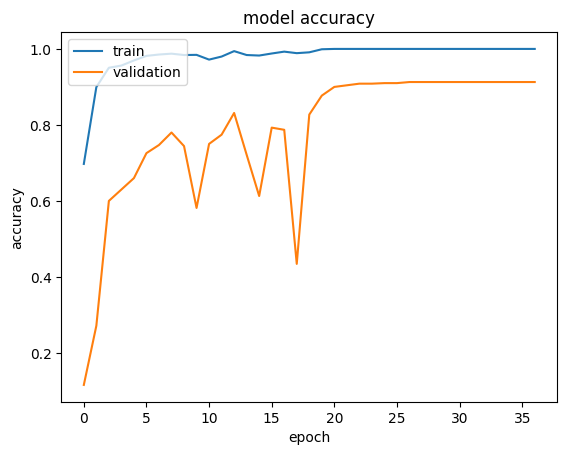

In [19]:
plt.plot(hist_concat.history['accuracy'])
plt.plot(hist_concat.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','precision','recall'], loc='upper left')
plt.show()

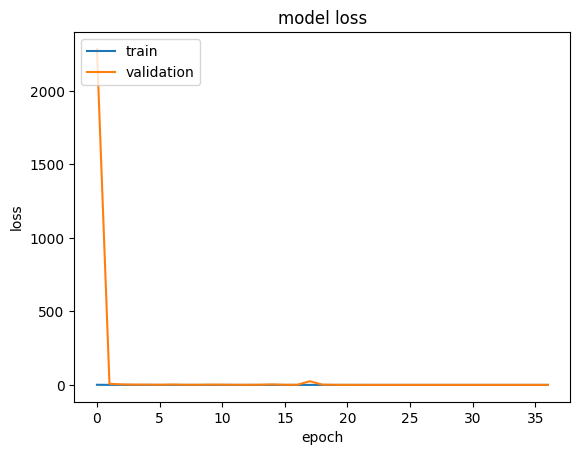

In [20]:
plt.plot(hist_concat.history['loss'])
plt.plot(hist_concat.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','recall'], loc='upper left')
plt.show()

Test Confusion Matrix
[[71  0  0  1  0  0  0]
 [ 0 67  4  1 12  1  4]
 [ 0  6 52  1  3  1  4]
 [ 1  1  2 75  3  1  0]
 [ 0  8  3  0 77  1  3]
 [ 0  0  0  0  2 82  0]
 [ 0  3  1  0  1  1 67]]


<Axes: >

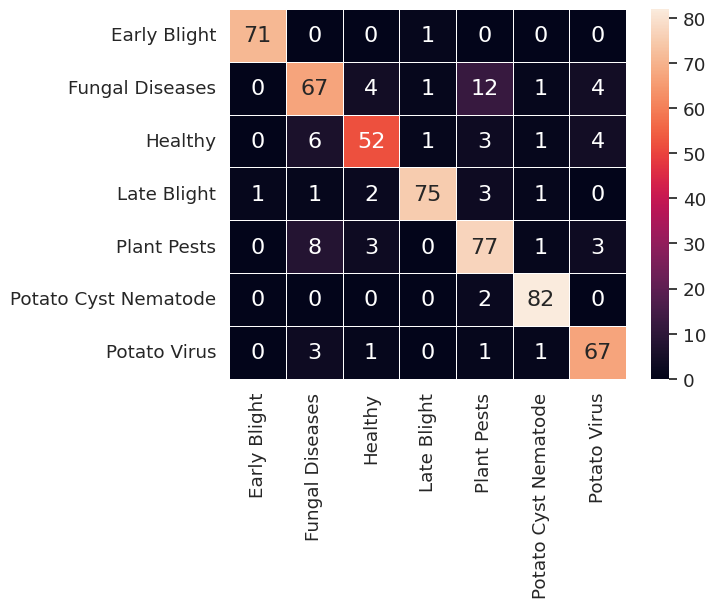

In [21]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
class_names = labels
print('Test Confusion Matrix')
cm_dense = confusion_matrix(Y_test, y_pred)
print(cm_dense)
sn.set(font_scale=1.2)  # for label size
sn.heatmap(cm_dense, annot=True, fmt="d", linewidths=.5, annot_kws={"size": 16},xticklabels=class_names, yticklabels=class_names)